## GROUP MEMBERS
- Amui Gayle
- Atieh Armin

## SETUP

We need to analyze the results of our recommendations for all the algorithms explored and so we will be exploring that in this notebook. But first we need to import all necessary modules 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations
from pathlib import Path
from lenskit import topn
from lenskit.metrics.predict import rmse

## Data Loading

Lets load all our recommendations into a single recommendation table and our predictions in a single prediction table

In [14]:
recs = []

for file in results.glob("*-recs.csv"):
    rec = pd.read_csv(file, sep=',')
    rec["algorithm"] = file.name.split("-")[1]
    recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'algorithm': 'category'})
recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8749100 entries, 0 to 8749099
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   item       int64   
 1   score      float64 
 2   user       int64   
 3   rank       int64   
 4   algorithm  category
dtypes: category(1), float64(1), int64(3)
memory usage: 275.3 MB


In [20]:
recs.head()

,item,score,user,rank,algorithm
0,17,1.070034,15,1,IMF
1,1,1.029546,15,2,IMF
2,62,1.024624,15,3,IMF
3,356,0.990765,15,4,IMF
4,110,0.985524,15,5,IMF


In [21]:
rec_algos = recs['algorithm'].unique()
rec_algos

['IMF', 'UU', 'Bias', 'II', 'SVD', 'Pop', 'EMF']
Categories (7, object): ['Bias', 'EMF', 'II', 'IMF', 'Pop', 'SVD', 'UU']

In [22]:
preds = []

for file in results.glob("*-pred.csv"):
    pred = pd.read_csv(file, sep=',')
    pred["algorithm"] = file.name.split("-")[1]
    preds.append(pred)

preds = pd.concat(preds, ignore_index=True)
preds = preds.astype({'algorithm': 'category'})
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625000 entries, 0 to 624999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   user        625000 non-null  int64   
 1   item        625000 non-null  int64   
 2   rating      625000 non-null  float64 
 3   timestamp   625000 non-null  int64   
 4   prediction  624827 non-null  float64 
 5   algorithm   625000 non-null  category
dtypes: category(1), float64(2), int64(3)
memory usage: 24.4 MB


In [65]:
preds.head()

,user,item,rating,timestamp,prediction,algorithm
0,89,3081,4.0,985558814,3.889566,EMF
1,89,715,5.0,985559129,3.997274,EMF
2,89,4340,2.0,1005854895,2.489257,EMF
3,89,2710,2.0,985558148,3.173867,EMF
4,89,2606,2.0,985557009,2.992615,EMF


In order to evaluate our algorithms, we will need some ground truth data. The test data loaded here will serve as that ground truth.

In [8]:
partitions = Path('data')

In [9]:
test = []
for file in partitions.glob("test-*.parquet"):
    test.append(pd.read_parquet(file).assign(part=file.stem.replace('.csv', '')))
   
test = pd.concat(test)
test.index.names = ['index']
test.head()

,user,item,rating,timestamp,part
index,,,,,
9429,89,3081,4.0,985558814,test-2
9377,89,715,5.0,985559129,test-2
9488,89,4340,2.0,1005854895,test-2
9403,89,2710,2.0,985558148,test-2
9398,89,2606,2.0,985557009,test-2


In [35]:
test = test.drop(test[test['part'] == 'test-5'].index)

In [36]:
list(test['part'].unique())

['test-4', 'test-0', 'test-1', 'test-3', 'test-2']

## NDCG 

In order to test the quality of our ranked user recommendations we will be using NDCG as our metric. 

In [37]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

/Users/amuigayle/opt/anaconda3/lib/python3.9/site-packages/lenskit/topn.py:152: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, df in res.groupby(ug_cols):


nrecs  ndcg  ntruth
algorithm user                     
Bias      89     50.0   0.0       5
          100    50.0   0.0       5
          132    50.0   0.0       5
          141    50.0   0.0       5
          173    50.0   0.0       4

We will reshape the 'results' dataframe by stacking the columns to index and then we will visualize the performance of our algorithms using a barchart. 

In [49]:
pltData = (results.drop(columns=['nrecs', 'ntruth']).stack()).reset_index()
pltData.columns = ['algorithm', 'user', 'metric', 'val']
pltData.head()

,algorithm,user,metric,val
0,Bias,89,ndcg,0.0
1,Bias,100,ndcg,0.0
2,Bias,132,ndcg,0.0
3,Bias,141,ndcg,0.0
4,Bias,173,ndcg,0.0


In [55]:
pltData[pltData['algorithm']=='Pop'].head()

,algorithm,user,metric,val
100000,Pop,89,ndcg,0.000000
100001,Pop,100,ndcg,0.217548
100002,Pop,132,ndcg,0.113468
100003,Pop,141,ndcg,0.084946
100004,Pop,173,ndcg,0.000000


Now lets visualize the performance of each algorithm

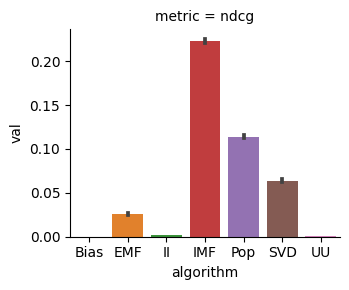

In [56]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=1.2, height=3, sharey=False)

NDCG is typically normalized to be between 0 and 1 with 1 representing the most relevant ranking list posible. The average NDCG appears to be on the lower side of the scale for most algorithms indicating the top n recommendation list was not the most relavant. Of these algorithms IMF does genarte a more relevant ranked list of recommendations.  

## RMSE

We also want to assess the accuracy of the predicted user ratings in our prediction dataset and to do this we will use the RMSE metric. Here we visualize the RMSE of each of our prediction algorithms.

In [57]:
user_rmse = preds.groupby(['algorithm', 'user']).apply(lambda df: rmse(df['prediction'], df['rating']))
user_rmse = user_rmse.reset_index(name='RMSE')

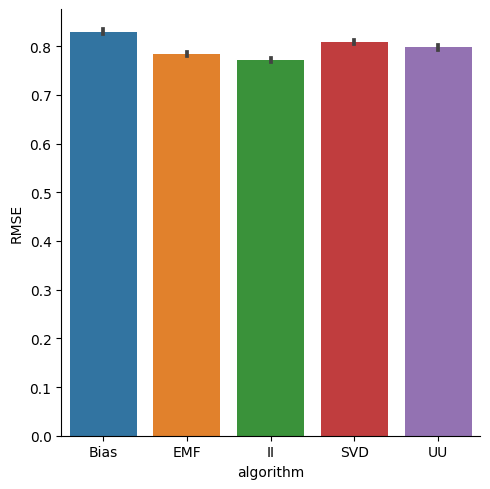

In [63]:
sns.catplot(x='algorithm', y='RMSE', data=user_rmse, kind='bar')
plt.show()

On average our predicted ratings seem to be off by 0.8 which doesnt seem too bad in the context of ratings. 

## Content Based Recommendation

We now add the results of the content-based recommendation. We used genome tags to find the similarities between user tag vector and the movie’s tag vector to be able to recommend movies to users. So it doesn't make sense to test it as a rating predictor.
Thus, nDCG is a better metric for this task and it is used in ranking tasks where the goal is to present a list of items in an order that is relevant to the user's preferences. It evaluates the quality of the ranking by considering the position of the relevant items in the recommendation list. 
Now, we just add genome results to the nDCG plot.

In [5]:
recs = []
results = Path('results')
for file in results.glob("*-recs.csv"):
    rec = pd.read_csv(file, sep=',')
    rec["algorithm"] = file.name.split("-")[1]
    recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'algorithm': 'category'})
recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999100 entries, 0 to 9999099
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   item       int64   
 1   score      float64 
 2   user       int64   
 3   rank       int64   
 4   algorithm  category
dtypes: category(1), float64(1), int64(3)
memory usage: 314.7 MB


In [10]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

nrecs  ndcg  ntruth
algorithm user                     
Bias      3      50.0   0.0       5
          13     50.0   0.0       5
          57     50.0   0.0       5
          65     50.0   0.0       5
          74     50.0   0.0       5

In [11]:
rec_algos = recs['algorithm'].unique()
rec_algos

['Pop', 'Bias', 'UU', 'II', 'SVD', 'genome', 'EMF', 'IMF']
Categories (8, object): ['Bias', 'EMF', 'II', 'IMF', 'Pop', 'SVD', 'UU', 'genome']

In [12]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.ndcg)
results = rla.compute(recs, test, include_missing=True)
results = results.fillna(0)
results.head()

nrecs  ndcg  ntruth
algorithm user                     
Bias      3      50.0   0.0       5
          13     50.0   0.0       5
          57     50.0   0.0       5
          65     50.0   0.0       5
          74     50.0   0.0       5

In [13]:
pltData = (results.drop(columns=['nrecs', 'ntruth']).stack()).reset_index()
pltData.columns = ['algorithm', 'user', 'metric', 'val']
pltData.head()

,algorithm,user,metric,val
0,Bias,3,ndcg,0.0
1,Bias,13,ndcg,0.0
2,Bias,57,ndcg,0.0
3,Bias,65,ndcg,0.0
4,Bias,74,ndcg,0.0


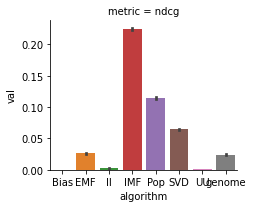

In [14]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=1.2, height=3, sharey=False)